# Experimental Energy Time Series Forecasting Notebook

This notebook demonstrates an end-to-end workflow for preparing, modeling, and evaluating energy consumption (or generation) time series using the `energy_pred` module plus standard Python ML tools.

In [5]:
# 1. Environment Setup and Configuration
import sys, os, random, time, json, math, warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
try:
    import torch  # optional
    torch.manual_seed(SEED)
except ImportError:
    torch = None

pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 160)

print(f"Python {sys.version.split()[0]}")
print("Torch available:" , torch is not None)


Python 3.13.7
Torch available: True


In [8]:
# 2. Import Libraries and energy_pred Module
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
sys.path.append('/home/sultanan/energy')
try:
    from energy_pred import (
        NaiveForecaster,
        SeasonalNaiveForecaster,
        MovingAverageForecaster,
        ExpSmoothingForecaster,
        mae, mape, rmse,
        train_test_split_chronological,
    )
    print("Imported energy_pred successfully.")
except ImportError as e:
    raise ImportError("energy_pred module not found. Ensure project root is on sys.path or installed.") from e


Imported energy_pred successfully.


In [13]:
# 3. Load Raw Time Series Data From GicaHack CSV Exports
import pathlib
DATA_DIR = pathlib.Path('/home/sultanan/datasets/energy/GicaHack')
assert DATA_DIR.exists(), f"Data directory not found: {DATA_DIR}"
files = sorted(DATA_DIR.glob('*.csv'))
print(f"Found {len(files)} CSV files:")
# for f in files:
#     print(' -', f.name)

if not files:
    raise FileNotFoundError('No CSV files found in data directory.')

frames = []
for fp in files:
    # Files are semicolon delimited; using python engine for robustness on special chars
    # check if file is not empty
    if os.path.getsize(fp) == 0:
        print(f"Skipping empty file: {fp.name}")
        continue
    df_part = pd.read_csv(fp, sep=';', engine='python')
    frames.append(df_part)

raw_df = pd.concat(frames, ignore_index=True)
print('Raw concatenated shape:', raw_df.shape)
print('Original columns:', list(raw_df.columns))

# Rename verbose measurement columns to cleaner names
colmap = {
    'Meter': 'meter',
    'Clock (8:0-0:1.0.0*255:2)': 'timestamp',
    'Active Energy Import (3:1-0:1.8.0*255:2)': 'energy_import',
    'Active Energy Export (3:1-0:2.8.0*255:2)': 'energy_export',
    'TransFullCoef': 'transform_coef'
}
raw_df = raw_df.rename(columns=colmap)

# Parse timestamp (day-first format like 08.06.2025 06:15:00)
raw_df['timestamp'] = pd.to_datetime(raw_df['timestamp'], format='%d.%m.%Y %H:%M:%S', errors='coerce', dayfirst=True)

# Basic cleaning: drop completely invalid rows
raw_df = raw_df.dropna(subset=['timestamp'])

# Sort
raw_df = raw_df.sort_values(['meter', 'timestamp']).reset_index(drop=True)

# Compute per-interval import difference (assumes cumulative kWh or Wh; treat as kWh baseline)
raw_df['import_diff'] = raw_df.groupby('meter')['energy_import'].diff()
raw_df['export_diff'] = raw_df.groupby('meter')['energy_export'].diff()

# Remove negative or zero diffs (possible counter resets / duplicates)
for c in ['import_diff', 'export_diff']:
    raw_df.loc[raw_df[c] <= 0, c] = np.nan

print(raw_df.head())
print(raw_df.tail())
print(raw_df[['meter']].nunique().rename({'meter':'n_meters'}))
print('Date range:', raw_df['timestamp'].min(), '->', raw_df['timestamp'].max())
print('Total rows:', len(raw_df))


Found 28 CSV files:
Skipping empty file: 03.06.2025 06_00_All measuring points_ExportFile.csv
Skipping empty file: 03.06.2025 18_01_All measuring points_ExportFile.csv
Skipping empty file: 04.06.2025 06_00_All measuring points_ExportFile.csv
Raw concatenated shape: (2254330, 6)
Original columns: ['Meter', 'Clock (8:0-0:1.0.0*255:2)', 'Active Energy Import (3:1-0:1.8.0*255:2)', 'Active Energy Export (3:1-0:2.8.0*255:2)', 'TransFullCoef', 'Unnamed: 5']
      meter           timestamp  energy_import  energy_export  transform_coef  Unnamed: 5  import_diff  export_diff
0  13836498 2025-06-01 12:15:00      6517117.0          469.0             1.0         NaN          NaN          NaN
1  13836498 2025-06-01 12:30:00      6517160.0          469.0             1.0         NaN         43.0          NaN
2  13836498 2025-06-01 12:45:00      6517205.0          469.0             1.0         NaN         45.0          NaN
3  13836498 2025-06-01 13:00:00      6517249.0          469.0             1.0    

In [14]:
# 4. Initial Data Audit and Sanity Checks (Meter Dataset)
# Check uniqueness per meter-timestamp
duplicates = raw_df.duplicated(subset=['meter','timestamp']).sum()
print('Duplicate meter-timestamp rows:', duplicates)

# Ensure overall chronological order inside each meter
violations = 0
for m, grp in raw_df.groupby('meter'):
    if not grp['timestamp'].is_monotonic_increasing:
        violations += 1
print('Meters with ordering violations:', violations)

# Identify sampling interval distribution (expect 15 minutes)
raw_df['delta_min'] = raw_df.groupby('meter')['timestamp'].diff().dt.total_seconds() / 60.0
interval_counts = raw_df['delta_min'].value_counts().sort_index()
print('Interval minute counts:\n', interval_counts.head(10))

expected_interval = 15
gap_mask = (raw_df['delta_min'].notna()) & (raw_df['delta_min'] > expected_interval)
print('Intervals > expected (potential gaps):', gap_mask.sum())

# Constant columns
nunique = raw_df.nunique()
print('Potential constant columns:', nunique[nunique <= 1].index.tolist())

# Basic distribution stats for diffs
print(raw_df[['import_diff','export_diff']].describe(percentiles=[0.01,0.5,0.99]))


Duplicate meter-timestamp rows: 4946
Meters with ordering violations: 0
Interval minute counts:
 delta_min
0.0         4946
15.0      758341
30.0         900
45.0         299
60.0     1444307
75.0         112
90.0           2
105.0          2
120.0      14409
180.0        276
Name: count, dtype: int64
Intervals > expected (potential gaps): 1479172
Potential constant columns: ['Unnamed: 5']
        import_diff    export_diff
count  1.893221e+06   15392.000000
mean   2.578373e+02    1785.869543
std    4.588034e+03    5739.761231
min    1.000000e+00       1.000000
1%     2.000000e+00       1.000000
50%    7.500000e+01     198.000000
99%    2.865000e+03   14279.100000
max    2.953920e+06  303702.000000


In [17]:
# 5. Handle Timestamps, Timezone, and Indexing (Per Meter Extraction)
# Assume local times are naive and represent local timezone; treat as UTC for now (adjust if TZ known)
# Choose a single meter for univariate forecasting demonstration
primary_meter = raw_df['meter'].mode().iloc[0]
print('Primary meter selected:', primary_meter)
series_df = raw_df.loc[raw_df['meter']==primary_meter, ['timestamp','import_diff']].copy()

# Because import_diff is energy over interval (kWh), we can treat it as consumption for forecasting
series_df = series_df.dropna(subset=['import_diff'])  # drop initial NaNs from diff
series_df = series_df.set_index('timestamp').sort_index()
print('Initial index unique:', series_df.index.is_unique)
if not series_df.index.is_unique:
    # Aggregate duplicates BEFORE any reindex attempt
    series_df = series_df.groupby(level=0)['import_diff'].mean().to_frame()
    print('Aggregated duplicates. Index unique now:', series_df.index.is_unique)

# Build full regular 15-min grid and reindex
full_index = pd.date_range(series_df.index.min(), series_df.index.max(), freq='15T')
series_df = series_df.reindex(full_index)
series_df.index.name = 'timestamp'
print('After reindex shape:', series_df.shape)
print('Missing after reindex (gaps):', series_df['import_diff'].isna().sum())
series_df.head()

Primary meter selected: 14461598
Initial index unique: True
After reindex shape: (1379, 1)
Missing after reindex (gaps): 2


,import_diff
timestamp,
2025-05-25 03:30:00,37.0
2025-05-25 03:45:00,99.0
2025-05-25 04:00:00,3.0
2025-05-25 04:15:00,3.0
2025-05-25 04:30:00,29.0


In [18]:
# 5a. Resolve Duplicate Timestamps Before Reindexing
# Some meters may have duplicate timestamp rows (e.g., multiple readings in same 15-min slot)
# Strategy: aggregate duplicates by taking mean of import_diff (could also sum if confirmed incremental)

# Identify duplicates
dup_counts = series_df.index.value_counts()
if (dup_counts > 1).any():
    print('Duplicate timestamps detected -> aggregating by mean')
    series_df = series_df.groupby(level=0)['import_diff'].mean().to_frame()
else:
    print('No duplicate timestamps in selected meter.')

# After aggregation ensure index unique
assert series_df.index.is_unique

# Reindex now to full grid
full_index = pd.date_range(series_df.index.min(), series_df.index.max(), freq='15T')
series_df = series_df.reindex(full_index)
series_df.index.name = 'timestamp'
print('Reindexed shape:', series_df.shape)
print('Missing after reindex:', series_df['import_diff'].isna().sum())

No duplicate timestamps in selected meter.
Reindexed shape: (1379, 1)
Missing after reindex: 2


In [19]:
# 6. Gap Filling / Imputation
# Strategy:
# - Short gaps (<= 2 consecutive missing intervals) -> linear interpolation
# - Longer gaps -> leave as NaN or fill with rolling median (flagged)

series_work = series_df.copy()

# Identify consecutive NaN runs
is_na = series_work['import_diff'].isna().astype(int)
# Group consecutive segments
segment_id = (is_na.diff().fillna(0) != 0).cumsum()
segments = series_work.assign(_na=is_na, _seg=segment_id)
missing_segments = segments[segments._na == 1].groupby('_seg').size()

short_threshold = 2  # 2 * 15min = 30 minutes
short_segments = missing_segments[missing_segments <= short_threshold]
long_segments = missing_segments[missing_segments > short_threshold]
print(f"Short gap segments: {len(short_segments)} | Long gap segments: {len(long_segments)}")

# Interpolate globally first
series_work['import_diff_interp'] = series_work['import_diff'].interpolate(method='time', limit=short_threshold)

# For long gaps apply rolling median fill (window=96 ~ 24h) where still NaN
still_nan = series_work['import_diff_interp'].isna()
series_work.loc[still_nan, 'import_diff_interp'] = (
    series_work['import_diff'].rolling(window=96, min_periods=12, center=True).median()[still_nan]
)

# Flag remaining missing
remaining = series_work['import_diff_interp'].isna().sum()
print('Remaining NaNs after strategy:', remaining)

series_work['used_fallback_fill'] = series_work['import_diff'].isna() & series_work['import_diff_interp'].notna()

series_clean = series_work['import_diff_interp'].rename('value').to_frame()
print(series_clean.head())


Short gap segments: 1 | Long gap segments: 0
Remaining NaNs after strategy: 0
                     value
timestamp                 
2025-05-25 03:30:00   37.0
2025-05-25 03:45:00   99.0
2025-05-25 04:00:00    3.0
2025-05-25 04:15:00    3.0
2025-05-25 04:30:00   29.0


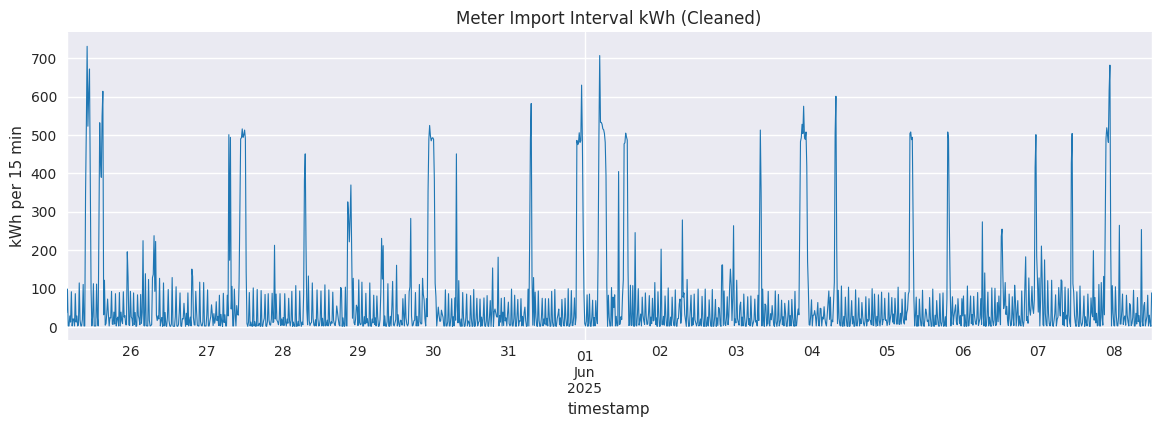

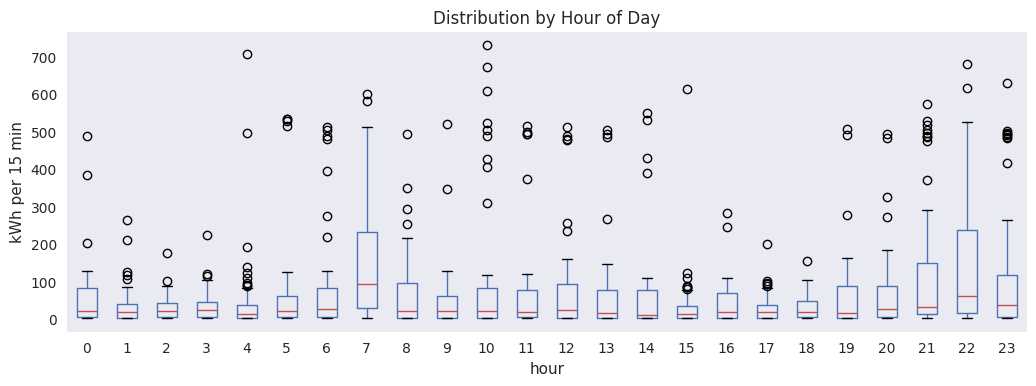

In [20]:
# 7. Visualization of Cleaned Series
fig, ax = plt.subplots(figsize=(14,4))
series_clean['value'].plot(ax=ax, lw=0.8, color='tab:blue')
ax.set_title('Meter Import Interval kWh (Cleaned)')
ax.set_ylabel('kWh per 15 min')
plt.show()

# Daily profile (boxplot by hour-of-day)
daily_prof = series_clean.copy()
daily_prof['hour'] = daily_prof.index.hour
fig, ax = plt.subplots(figsize=(12,4))
daily_prof.boxplot(column='value', by='hour', ax=ax, grid=False)
ax.set_title('Distribution by Hour of Day')
ax.set_ylabel('kWh per 15 min')
plt.suptitle('')
plt.show()


Train length: 1283 Test length: 96
           model         MAE        RMSE      MAPE
0          Naive   73.406250  154.609960  0.744780
3   ExpSmoothing   79.694349  136.308471  7.878551
2  MovingAverage   81.966146  136.096761  8.549676
1  SeasonalNaive  101.041667  168.780491  9.329914


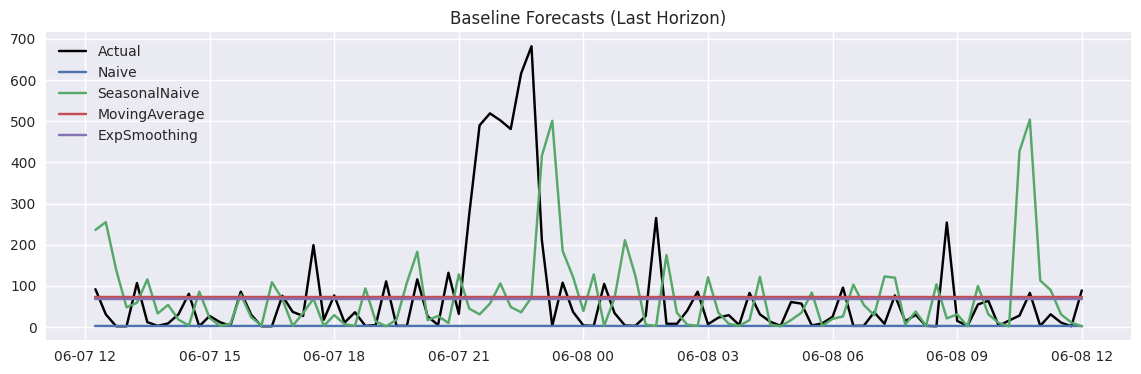

In [21]:
# 8. Baseline Forecasting Evaluation
# Define horizon = last N points (e.g., last day = 96 intervals for 15-min data)
H = 96
values = series_clean['value'].astype(float)
if values.isna().sum()>0:
    print('Warning: still NaNs present, dropping for training/eval')
    values = values.dropna()

train, test = values.iloc[:-H], values.iloc[-H:]
print('Train length:', len(train), 'Test length:', len(test))

results = []
models = []

# Naive
m_naive = NaiveForecaster().fit(train.values)
pred_naive = m_naive.predict(H)
results.append(('Naive', mae(test.values, pred_naive), rmse(test.values, pred_naive), mape(test.values, pred_naive)))
models.append(("Naive", pred_naive))

# Seasonal naive (daily = 96, fallback if not enough length)
if len(train) >= 96:
    m_seasonal = SeasonalNaiveForecaster(season_length=96).fit(train.values)
    pred_seasonal = m_seasonal.predict(H)
    results.append(('SeasonalNaive', mae(test.values, pred_seasonal), rmse(test.values, pred_seasonal), mape(test.values, pred_seasonal)))
    models.append(("SeasonalNaive", pred_seasonal))

# Moving average
m_ma = MovingAverageForecaster(window=min(96, max(4, len(train)//10))).fit(train.values)
pred_ma = m_ma.predict(H)
results.append(('MovingAverage', mae(test.values, pred_ma), rmse(test.values, pred_ma), mape(test.values, pred_ma)))
models.append(("MovingAverage", pred_ma))

# Exponential smoothing
m_exp = ExpSmoothingForecaster(alpha=0.3).fit(train.values)
pred_exp = m_exp.predict(H)
results.append(('ExpSmoothing', mae(test.values, pred_exp), rmse(test.values, pred_exp), mape(test.values, pred_exp)))
models.append(("ExpSmoothing", pred_exp))

# Display metrics
metrics_df = pd.DataFrame(results, columns=['model','MAE','RMSE','MAPE']).sort_values('MAE')
print(metrics_df)

# Plot last part of series with forecasts
fig, ax = plt.subplots(figsize=(14,4))
ax.plot(test.index, test.values, label='Actual', color='black')
for name, pred in models:
    ax.plot(test.index, pred, label=name)
ax.set_title('Baseline Forecasts (Last Horizon)')
ax.legend()
plt.show()


## 9. Next Improvement Ideas

- Add calendar features (hour-of-day, day-of-week) and train a small regression model (e.g., LightGBM or linear).
- Detect and handle counter resets more robustly (flag large negative jumps before diffing).
- Build multi-meter panel forecasting by stacking meters and adding meter embeddings.
- Add probabilistic forecasts using residual bootstrapping.
- Integrate anomaly detection to exclude outlier intervals before model fitting.
- Automate daily retraining and rolling backtest.
